# EDA from 04_29_2023

In [1]:
import pandas as pd
import numpy as np
import cv2
import time
import os
import random

### 1. Getting all file paths

In [2]:
# get all video paths
all_video_paths = os.listdir('/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original')
all_video_paths.sort()
print(len(all_video_paths))
print(all_video_paths[:10])

329
['VIRAT_S_000001.mp4', 'VIRAT_S_000002.mp4', 'VIRAT_S_000003.mp4', 'VIRAT_S_000004.mp4', 'VIRAT_S_000006.mp4', 'VIRAT_S_000101.mp4', 'VIRAT_S_000102.mp4', 'VIRAT_S_000200_00_000100_000171.mp4', 'VIRAT_S_000200_01_000226_000268.mp4', 'VIRAT_S_000200_02_000479_000635.mp4']


In [3]:
# get all annotation .object.txt paths
# from /annotations folder
all_object_paths = []
obj_p = os.listdir('/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations')
for string in obj_p:
    if string[-11:] == 'objects.txt':
        all_object_paths.append(string)
all_object_paths.sort()
print(len(all_object_paths))
print(all_object_paths[:10])

315
['VIRAT_S_000001.viratdata.objects.txt', 'VIRAT_S_000002.viratdata.objects.txt', 'VIRAT_S_000003.viratdata.objects.txt', 'VIRAT_S_000004.viratdata.objects.txt', 'VIRAT_S_000006.viratdata.objects.txt', 'VIRAT_S_000101.viratdata.objects.txt', 'VIRAT_S_000102.viratdata.objects.txt', 'VIRAT_S_000200_00_000100_000171.viratdata.objects.txt', 'VIRAT_S_000200_01_000226_000268.viratdata.objects.txt', 'VIRAT_S_000200_03_000657_000899.viratdata.objects.txt']


There is not a 1-to-1 mapping of annotations files to object.txt files, so let's make a dictionary to map them

In [4]:
# Map identifier strings (keys) to video and object filepaths

all_keys = {}
# first 7 videos have shorter identifier sequences
for i in range(7):
    key = all_video_paths[i][:14]
    keyed_video = all_video_paths[i]
    keyed_object = None
    for j in range(0, len(all_object_paths)):
        if all_object_paths[j][:14] == key:
            keyed_object = all_object_paths[j]
    all_keys[key] = [keyed_video, keyed_object]
# rest are longer
for i in range(7, len(all_video_paths)):
    key = all_video_paths[i][:23]
    keyed_video = all_video_paths[i]
    keyed_object = None
    for j in range(0, len(all_object_paths)):
        if all_object_paths[j][:23] == key:
            keyed_object = all_object_paths[j]
    all_keys[key] = [keyed_video, keyed_object]
all_keys

{'VIRAT_S_000001': ['VIRAT_S_000001.mp4',
  'VIRAT_S_000001.viratdata.objects.txt'],
 'VIRAT_S_000002': ['VIRAT_S_000002.mp4',
  'VIRAT_S_000002.viratdata.objects.txt'],
 'VIRAT_S_000003': ['VIRAT_S_000003.mp4',
  'VIRAT_S_000003.viratdata.objects.txt'],
 'VIRAT_S_000004': ['VIRAT_S_000004.mp4',
  'VIRAT_S_000004.viratdata.objects.txt'],
 'VIRAT_S_000006': ['VIRAT_S_000006.mp4',
  'VIRAT_S_000006.viratdata.objects.txt'],
 'VIRAT_S_000101': ['VIRAT_S_000101.mp4',
  'VIRAT_S_000101.viratdata.objects.txt'],
 'VIRAT_S_000102': ['VIRAT_S_000102.mp4',
  'VIRAT_S_000102.viratdata.objects.txt'],
 'VIRAT_S_000200_00_00010': ['VIRAT_S_000200_00_000100_000171.mp4',
  'VIRAT_S_000200_00_000100_000171.viratdata.objects.txt'],
 'VIRAT_S_000200_01_00022': ['VIRAT_S_000200_01_000226_000268.mp4',
  'VIRAT_S_000200_01_000226_000268.viratdata.objects.txt'],
 'VIRAT_S_000200_02_00047': ['VIRAT_S_000200_02_000479_000635.mp4', None],
 'VIRAT_S_000200_03_00065': ['VIRAT_S_000200_03_000657_000899.mp4',
  'VIR

In [5]:
# for usage, make a list of the keys
key_list = []
for key in all_keys.keys():
    key_list.append(key)

In [6]:
all_keys[key_list[0]]

['VIRAT_S_000001.mp4', 'VIRAT_S_000001.viratdata.objects.txt']

### 2. Grabbing all People
For every Person in video, write .jpg files with bounding boxes drawn on them.

This will be used to manual clean the data.

In [7]:
object_columns = ['Object_ID', 'Duration', 'Current_Frame', 'bbox_lefttop_x',
                  'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'Object_Type']

In [9]:
# Write .jpg images with bounding boxes for each person in video

def get_images_of_objects(video_path, object_path, color=(0, 255, 0), thickness=2):
    '''takes video path and object path,
    writes .jpg files for each person (Object_Type=1) in video
    with bounding box.
    Uses first frame which the person appears in'''
    
    # create parent folder for images
    loc = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/people_images/'
    folder = loc + video_path.split('.')[0]
    if not os.path.exists(folder):
        os.mkdir(folder)
    if object_path == None:
        return
    
    # get df
    loc = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/'
    full_object_path = loc + object_path
    df = pd.read_csv(full_object_path, sep=" ", names=object_columns, index_col=False)
    
    # get Object_IDs for all people
    obj_type = 1 # <-- change the object type if you want to see other objects (not people)
    people_ids = df[df['Object_Type'] == obj_type]['Object_ID'].unique()
    
    # loop through all people
    ppl_count = 0
    for obj_id in people_ids:
        ppl_count +=1
        # get index of first frame of object
        idx = pd.DataFrame(df[df['Object_ID'] == obj_id].iloc[0]).T.index.values[0]

        # Get Bounding Box coordinates
        x_min = df['bbox_lefttop_x'][idx]
        y_min = df['bbox_lefttop_y'][idx]
        x_max = df['bbox_lefttop_x'][idx] + df['bbox_width'][idx]
        y_max = df['bbox_lefttop_y'][idx] + df['bbox_height'][idx]

        # load video
        loc = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/'
        full_video_path = loc + video_path
        cap = cv2.VideoCapture(full_video_path)
        
        # set frame position
        frame_index = df.iloc[idx]['Current_Frame']
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        
        # read frame
        success, frame = cap.read()
        if not success:
            print("Failed to read the frame")
            return
        if success:
            # draw bounding box on the frame
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, thickness)
            
            # write frame to .jpg and store in parent folder
            filepath = folder + '/' + str(obj_id) + '.jpg'
            cv2.imwrite(filepath, frame)
        
        # end capture
        cap.release()
    print(video_path, ' has:\t', ppl_count, 'people')

In [10]:
# change i to get different videos
i = 0

video_path, object_path = all_keys[key_list[i]]
print(video_path)
print(object_path)

VIRAT_S_000001.mp4
VIRAT_S_000001.viratdata.objects.txt


Get images of people from first video

In [11]:
get_images_of_objects(video_path, object_path)

VIRAT_S_000001.mp4  has:	 11 people


Get images of people from all videos

In [81]:
%%time
for i in range(len(all_keys)):
    video_path, object_path = all_keys[key_list[i]]
    get_images_of_objects(video_path = video_path, object_path = object_path)

VIRAT_S_000001.mp4  has:	 11 people
VIRAT_S_000002.mp4  has:	 7 people
VIRAT_S_000003.mp4  has:	 6 people
VIRAT_S_000004.mp4  has:	 4 people
VIRAT_S_000006.mp4  has:	 11 people
VIRAT_S_000101.mp4  has:	 37 people
VIRAT_S_000102.mp4  has:	 76 people
VIRAT_S_000200_00_000100_000171.mp4  has:	 2 people
VIRAT_S_000200_01_000226_000268.mp4  has:	 1 people
VIRAT_S_000200_03_000657_000899.mp4  has:	 0 people
VIRAT_S_000200_04_000937_001443.mp4  has:	 41 people
VIRAT_S_000200_06_001693_001824.mp4  has:	 2 people
VIRAT_S_000201_00_000018_000380.mp4  has:	 38 people
VIRAT_S_000201_01_000384_000589.mp4  has:	 2 people
VIRAT_S_000201_02_000590_000623.mp4  has:	 5 people
VIRAT_S_000201_03_000640_000672.mp4  has:	 1 people
VIRAT_S_000201_05_001081_001215.mp4  has:	 3 people
VIRAT_S_000201_06_001354_001397.mp4  has:	 1 people
VIRAT_S_000201_07_001485_001581.mp4  has:	 2 people
VIRAT_S_000201_08_001652_001838.mp4  has:	 3 people
VIRAT_S_000202_00_000000_000977.mp4  has:	 12 people
VIRAT_S_000203_03_00

VIRAT_S_010201_06_000550_000600.mp4  has:	 19 people
VIRAT_S_010201_07_000601_000697.mp4  has:	 21 people
VIRAT_S_010201_08_000705_000739.mp4  has:	 6 people
VIRAT_S_010201_09_000770_000801.mp4  has:	 12 people
VIRAT_S_010202_00_000001_000033.mp4  has:	 7 people
VIRAT_S_010202_01_000055_000147.mp4  has:	 21 people
VIRAT_S_010202_02_000161_000189.mp4  has:	 4 people
VIRAT_S_010202_03_000313_000355.mp4  has:	 7 people
VIRAT_S_010202_06_000784_000873.mp4  has:	 35 people
VIRAT_S_010203_00_000047_000139.mp4  has:	 20 people
VIRAT_S_010203_02_000347_000397.mp4  has:	 20 people
VIRAT_S_010203_03_000400_000435.mp4  has:	 10 people
VIRAT_S_010203_04_000457_000511.mp4  has:	 32 people
VIRAT_S_010203_05_000515_000593.mp4  has:	 21 people
VIRAT_S_010203_06_000620_000760.mp4  has:	 49 people
VIRAT_S_010203_07_000775_000869.mp4  has:	 32 people
VIRAT_S_010203_08_000895_000975.mp4  has:	 37 people
VIRAT_S_010203_09_001010_001036.mp4  has:	 11 people
VIRAT_S_010203_10_001092_001121.mp4  has:	 18 peop

### Examine Videos

#### Q1: Are all people captured by the labels?
#### A1: No

Observe video 'VIRAT_S_000201_01_000384_000589.mp4' has only 2 people annotated, but more are present (I personally counted 16 when watching the video):

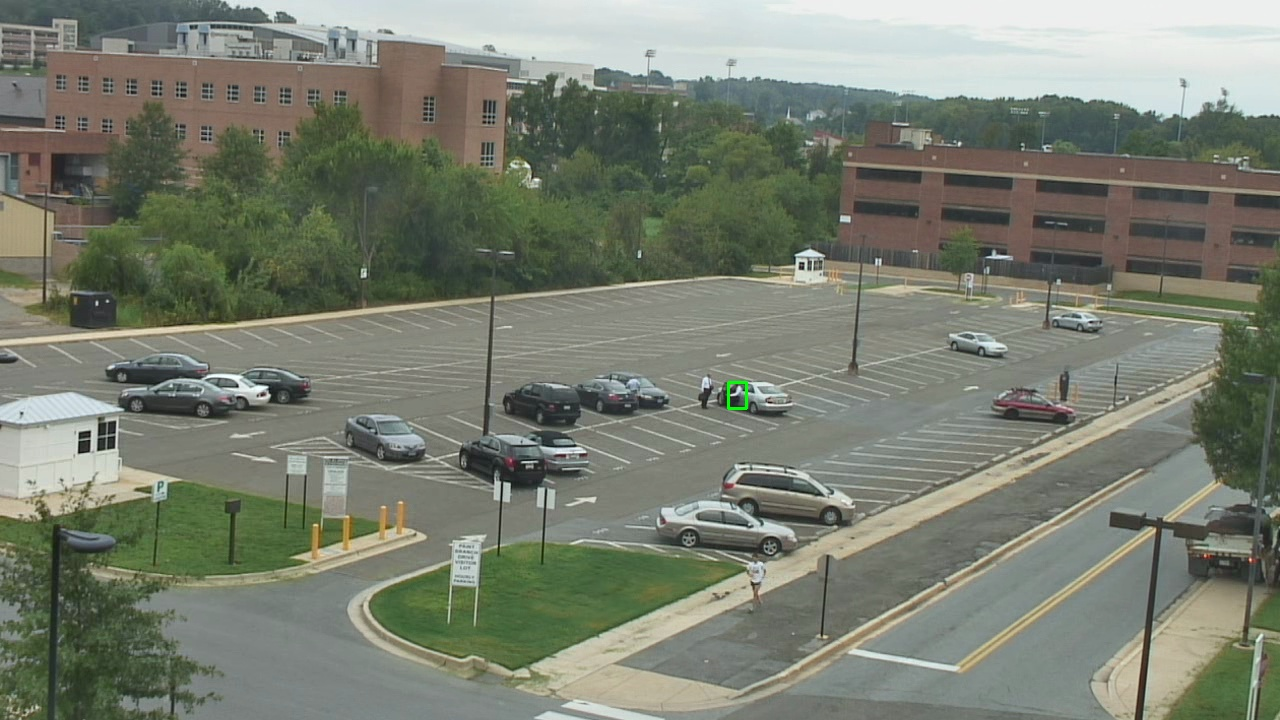

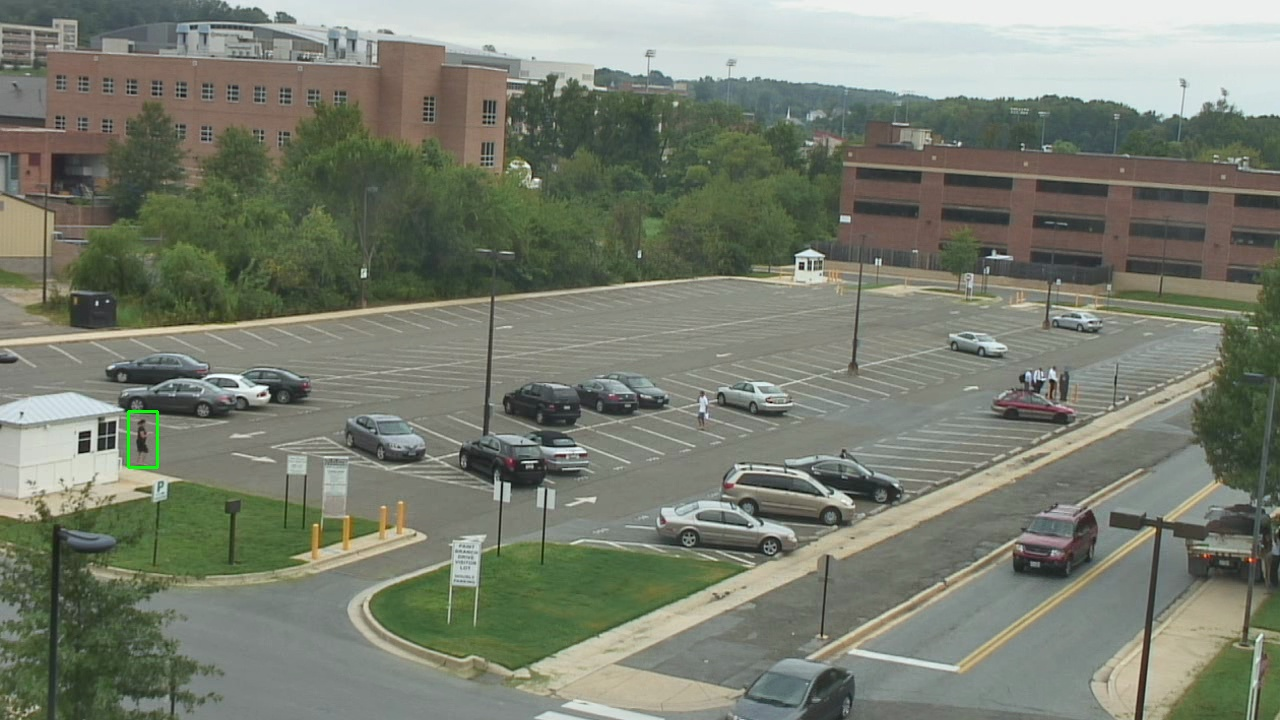

Looking at video, counted 16 people

Looking at `/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000201_01_000384_000589.viratdata.objects.txt`, observed only 4 objects total are annotated (2 people, 2 cars). .txt file is missing object_id 2... which leads me to believe this is corrupted data.

redownload the dataset and see if it is any different?

after redownloading this video & objects.txt file

same results. object_IDs = [1,3,4,5] with only 2 people

Compare against DIVA annotations? are they any better?
- Can do quick look first

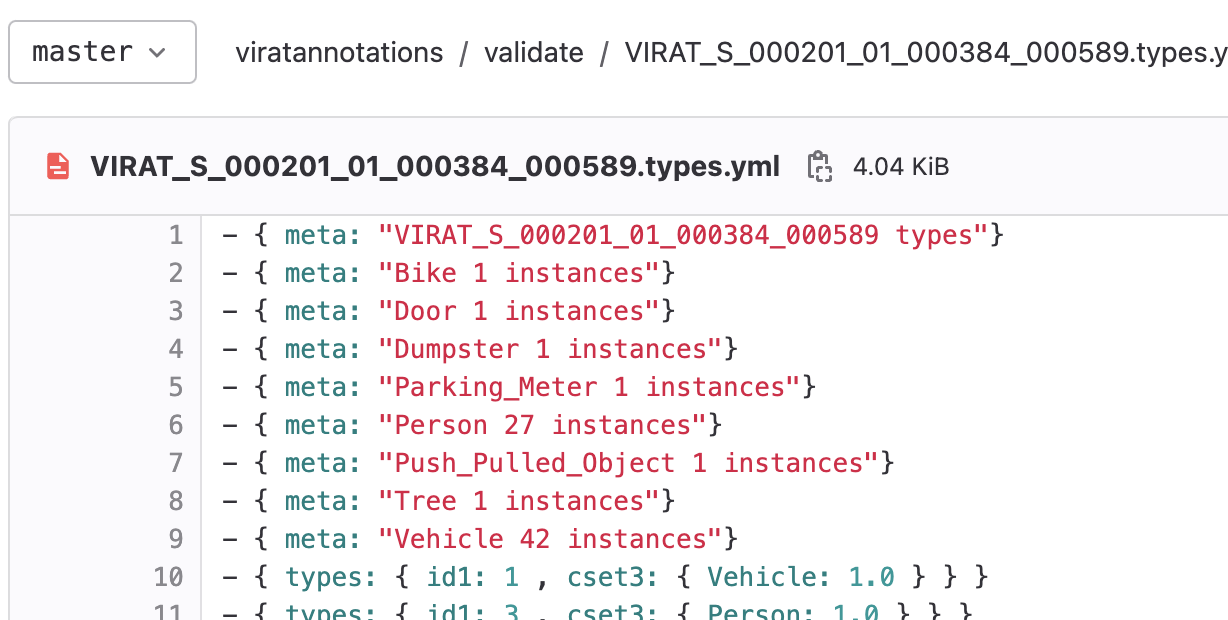

The IARPA DIVA annotations do seem to have more information. 

Documentation for them here: https://kwiver-diva.readthedocs.io/en/latest/introduction.html

In [15]:
!pip show pyyaml

Name: PyYAML
Version: 6.0
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /Users/p/miniconda3/envs/virat/lib/python3.11/site-packages
Requires: 
Required-by: jupyter-events


### Explore some data from VIRAT_S_000001.geom.yml

In [17]:
import yaml

file_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/diva_annotations/train/VIRAT_S_000001.geom.yml'
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

In [50]:
len(data)

179577

In [52]:
data[4]['geom']['src']

'truth'

In [66]:
7294 + 28872

36166

In [69]:
# count src: 'truth'
count = 0
for i in range(4, len(data)):
    try:
        if data[i]['geom']['src'] == 'truth':
            count += 1
    except:
        
count

179573

In [65]:
# count occlusion: 'partially'
count = 0
for i in range(4, len(data)):
    try: 
        if data[i]['geom']['occlusion'] == 'partially':
            count += 1
    except:
        count = count
print(count)

28872


In [70]:
# sum ( occlusion: 'partially', occlusion: 'mostly')
28872 + 7294

36166

In [72]:
# un-occluded object-frames
179573 - 36166

143407

In [42]:
data[4]['geom']['g0'].split(' ')

['1', '663', '77', '795']

In [41]:
my_list = data[4]['geom']['g0'].split(' ')
x_min, x_max = int(my_list[0]), int(my_list[1])
y_min, y_max = int(my_list[2]), int(my_list[3])

In [43]:
c_frame = data[4]['geom']['ts0']

### Show object 1 in image

In [166]:
# Show first object of first video

# load video
video_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000001.mp4'
cap = cv2.VideoCapture(video_path)

# set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, c_frame)

# read frame
success, frame = cap.read()
if not success:
    print("Failed to read the frame")
if success:
    # draw bounding box on the frame
    cv2.rectangle(frame, (x_min, x_max), (y_min, y_max), (0,255,0), 2)

    # write frame to .jpg and store in parent folder
    cv2.imshow(f"Frame {c_frame}", frame)
    cv2.waitKey(10000)
    
# end capture
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1);

Video: VIRAT_S_000001.mp4

File: VIRAT_S_000001.geom.yml

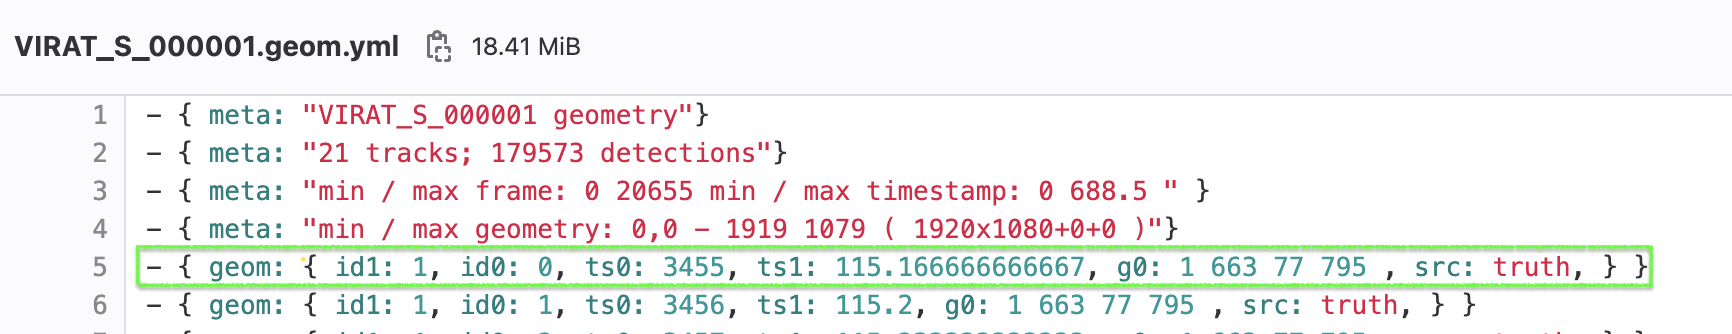

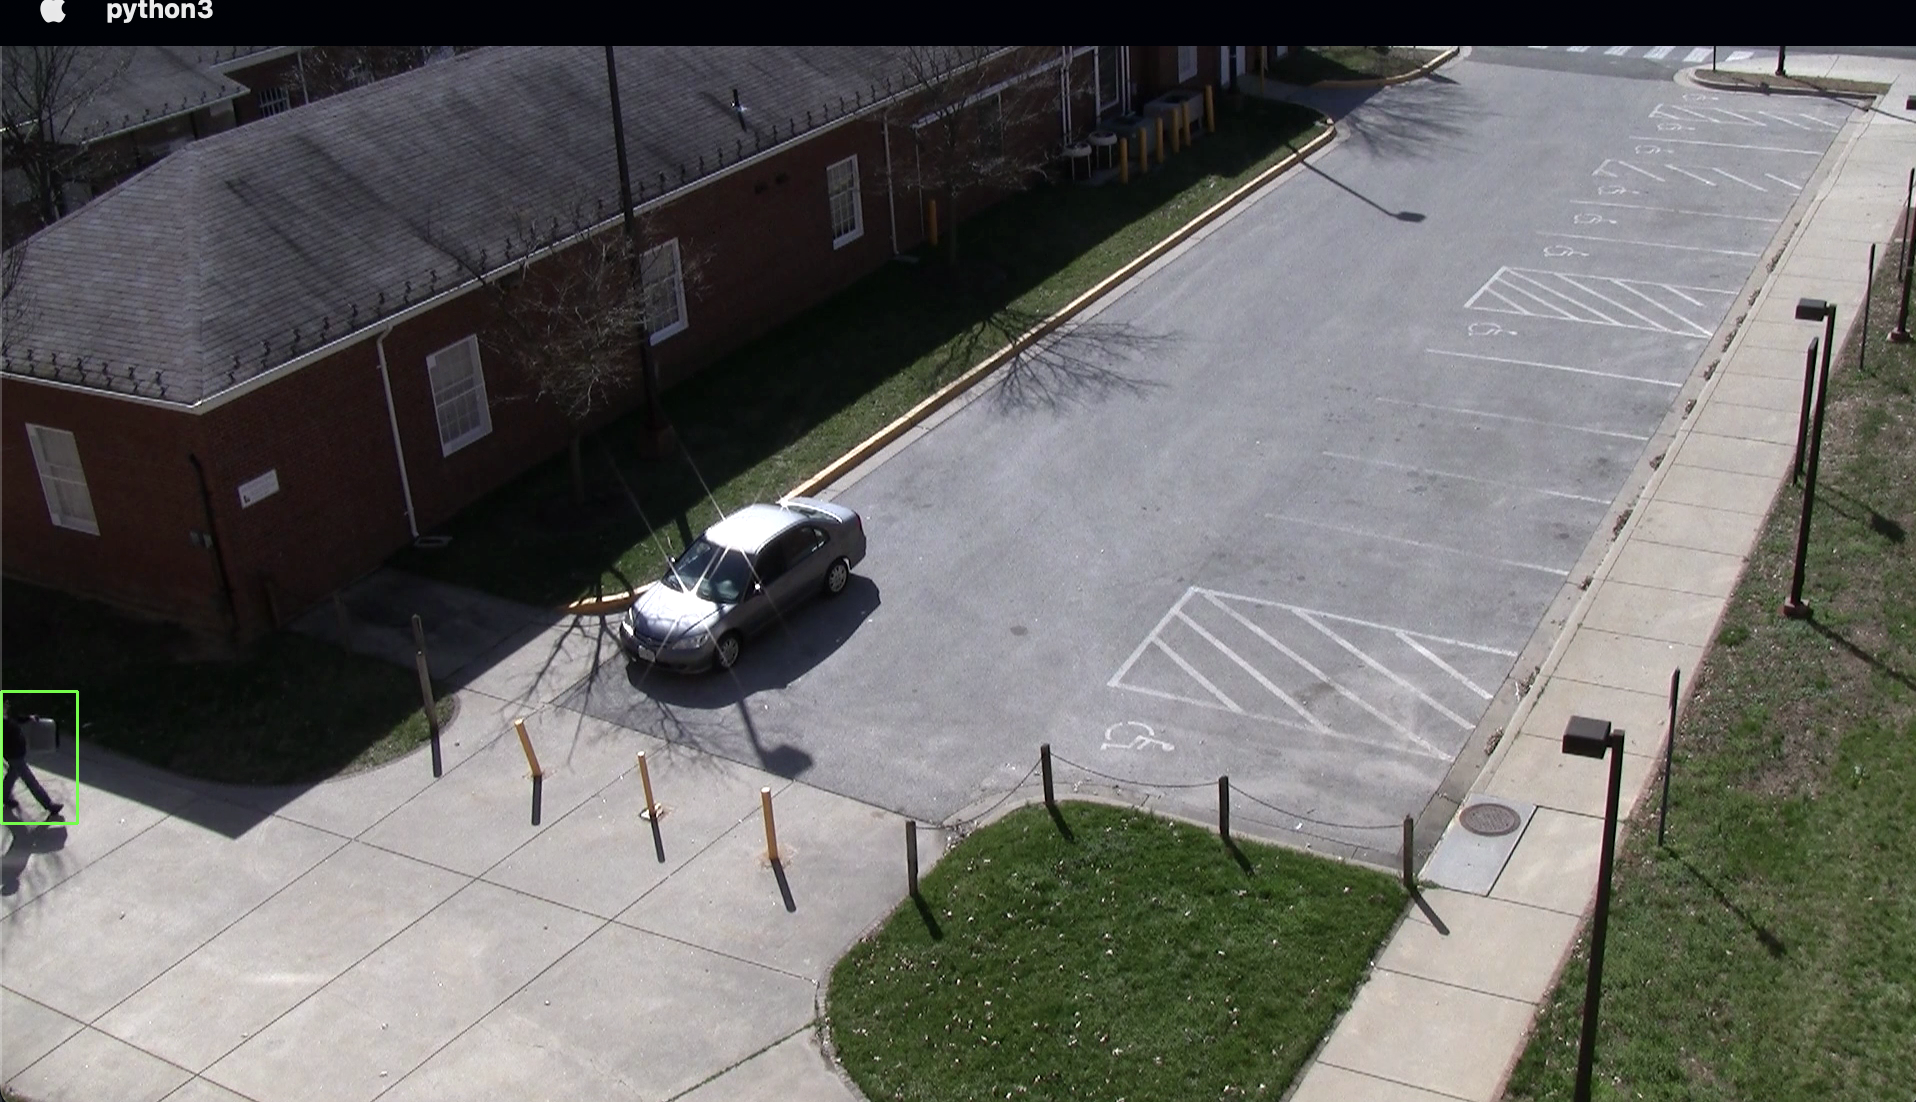

### Show Object 1 with bounding box in video

In [143]:
def get_track_data(video_path, geom_data, id1):
    track = []
    for i in geom_data:
        try:
            if (i['geom']['id1'] == id1):
                track.append(i)
        except:
            pass
    return track

In [144]:
def end_sequence(cap):
    cap.release() # Release video capture
    cv2.destroyAllWindows() # close windows
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1); # mac needs 4 loops of .waitKey(1) to to destroy windows..

In [210]:
def show_object_in_video(video_path, geom_data, id1, color=(0,255,0), thickness=2):
    
    # get track data
    track = get_track_data(video_path, geom_data, id1)
        
    # load video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
    
    # if there's no data, quit
    try:
        frame_number = track[0]['geom']['ts0']
    except:
        print('id1: ', id1, ' does not have any frame data')
        return
    
    count = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # set the frame position
    # loop through the frames
    while cap.isOpened():
        ret, frame = cap.read()
        #print('got2')
        if not ret:
            print("Error reading frame")
            break
    
        # If the current frame is in the track frames (ts0), draw the bounding box and display it
        if (frame_number in [i['geom']['ts0'] for i in track]):
            #print('got3')
            x_min, y_min, x_max, y_max = [int(j) for j in track[count]['geom']['g0'].split(' ')]
            
            cv2.rectangle(frame, (x_min,y_min), (x_max,y_max), color, thickness)
            cv2.imshow(f'id1:{id1}', frame)
        
        # End playback if not in track
        if (frame_number not in [i['geom']['ts0'] for i in track]):
            end_sequence(cap)
            break
        
        # Break the loop if 'q' key is pressed
        if cv2.waitKey(25) & 0xFF == ord('q'):
            end_sequence(cap)
            break
        
        frame_number += 1
        count += 1
        print(frame_number)     

### Show Object 1 with bounding box in video

In [208]:
file_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/diva_annotations/train/\
VIRAT_S_000001.geom.yml'
with open(file_path, 'r') as file:
    data_VIRAT_S_000001 = yaml.safe_load(file)

In [209]:
id1 = 5003
video_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000001.mp4'

show_object_in_video(video_path, data_VIRAT_S_000001, id1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


### Check a few others

In [224]:
# get all video paths for the DIVA annotations
all_video_paths = os.listdir('/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original')
all_video_paths.sort()
print(len(all_video_paths))
print(all_video_paths[:10])

329
['VIRAT_S_000001.mp4', 'VIRAT_S_000002.mp4', 'VIRAT_S_000003.mp4', 'VIRAT_S_000004.mp4', 'VIRAT_S_000006.mp4', 'VIRAT_S_000101.mp4', 'VIRAT_S_000102.mp4', 'VIRAT_S_000200_00_000100_000171.mp4', 'VIRAT_S_000200_01_000226_000268.mp4', 'VIRAT_S_000200_02_000479_000635.mp4']


In [220]:
# get all annotation .object.txt paths
# from /annotations folder
geom_paths = []
obj_p = os.listdir('/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/diva_annotations/train')
for string in obj_p:
    if string[-8:] == 'geom.yml':
        geom_paths.append(string)
geom_paths.sort()
print(len(geom_paths))
print(geom_paths[:10])

64
['VIRAT_S_000000.geom.yml', 'VIRAT_S_000001.geom.yml', 'VIRAT_S_000002.geom.yml', 'VIRAT_S_000005.geom.yml', 'VIRAT_S_000200_03_000657_000899.geom.yml', 'VIRAT_S_000200_05_001525_001575.geom.yml', 'VIRAT_S_000201_03_000640_000672.geom.yml', 'VIRAT_S_000201_05_001081_001215.geom.yml', 'VIRAT_S_000201_06_001354_001397.geom.yml', 'VIRAT_S_000201_07_001485_001581.geom.yml']


In [231]:
# Map identifier strings (keys) to video and object filepaths

diva_keys = {}
# first 7 videos have shorter identifier sequences
for i in range(7):
    key = all_video_paths[i][:14]
    keyed_video = all_video_paths[i]
    keyed_object = None
    for j in range(0, len(geom_paths)):
        if geom_paths[j][:14] == key:
            keyed_object = geom_paths[j]
    diva_keys[key] = [keyed_video, keyed_object]

# rest are longer
for i in range(7, len(all_video_paths)):
    key = all_video_paths[i][:23]
    keyed_video = all_video_paths[i]
    keyed_object = None
    for j in range(0, len(geom_paths)):
        if geom_paths[j][:23] == key:
            keyed_object = geom_paths[j]
    diva_keys[key] = [keyed_video, keyed_object]

In [232]:
# for usage, make a list of the keys
diva_list = []
for key in diva_keys.keys():
    diva_list.append(key)

In [234]:
train_geoms = []
for i in range(len(diva_keys)):
    if diva_keys[diva_list[i]][1] != None:
        train_geoms.append(diva_list[i])

### Check a few others

In [254]:
idx = 3 # change this

geom_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/diva_annotations/train/'
geom_path = geom_prefix + diva_keys[train_geoms[idx]][1]
print(geom_path)

vid_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/'
video_path = vid_prefix + diva_keys[train_geoms[idx]][0]
print(video_path)

/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/diva_annotations/train/VIRAT_S_000200_05_001525_001575.geom.yml
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000200_05_001525_001575.mp4


In [253]:
with open(geom_path, 'r') as file:
    data = yaml.safe_load(file)

In [274]:
id1 = 13 # change this. Observe id1 types in .types.yml file.

show_object_in_video(video_path, data, id1)

1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
Error reading frame


In [272]:
end_sequence(cap)

### 5. Establishing a benchmark
- Using YOLO to count people
- Comparing with ground truth (cleaned people data from 4)

### 6. Exploring Other Solutions
- https://pyimagesearch.com/2018/10/29/multi-object-tracking-with-dlib/
- https://pyimagesearch.com/2018/08/06/tracking-multiple-objects-with-opencv/
- https://arxiv.org/abs/1703.07402